In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

In [9]:
final_data=pd.read_csv('Final_Data.csv')
req=final_data.columns
req=req[1:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [5]:
lr=LogisticRegression(
random_state=1,
max_iter=200
)

The Accuracy Score is 0.8573648851900131
The Precision is 0.7346758132330161
The recall is 0.6685461135722915
The f1 score is 0.7000527148128624
The area under curve 0.9215580903414246


C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'ROC Curve')

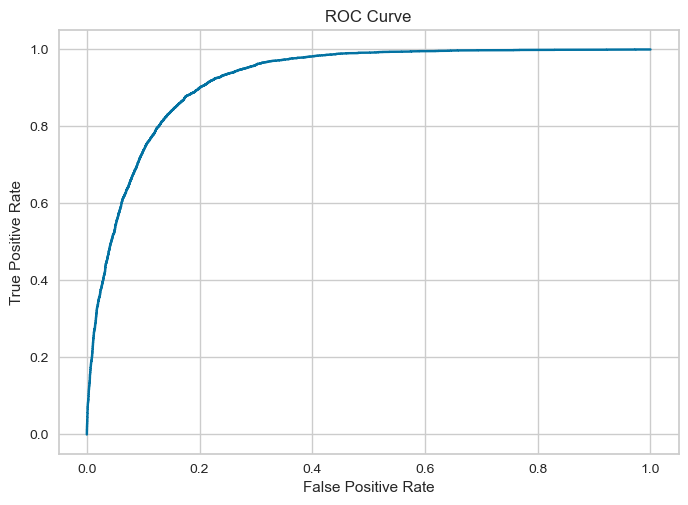

In [29]:
without=LogisticRegression(random_state=1,
                        max_iter=200,
                        penalty='none')
without.fit(train_x,train_y)
print("The Accuracy Score is {}".format(accuracy_score(without.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,without.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=without.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [10]:
from sklearn.model_selection import GridSearchCV
params = {
    'penalty' : ['l1','l2'],
    'solver' : ['newton-cg','liblinear']
}
best_param=GridSearchCV(estimator=lr,
                       param_grid=params)
best_param.fit(train_x,train_y)

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

GridSearchCV(estimator=LogisticRegression(max_iter=200, random_state=1),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [11]:
best_param=best_param.best_estimator_
best_param.fit(train_x,train_y)

LogisticRegression(max_iter=200, random_state=1, solver='newton-cg')

In [14]:
import matplotlib.pyplot as plt

The Accuracy Score is 0.8664393863431264
The Precision is 0.7388589881593111
The recall is 0.7028466106901495
The f1 score is 0.7204030226700252
The area under curve 0.9278083180412219


Text(0.5, 1.0, 'ROC Curve')

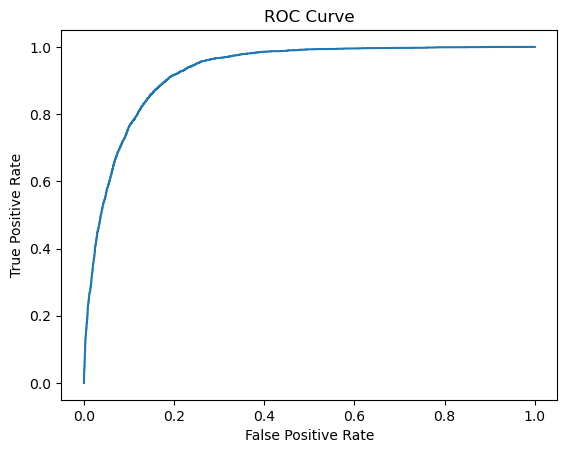

In [15]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [16]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [17]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8556076747337619
Top 4% capture 0.46713086217489247
Final eval metric 0.6613692684543272


In [18]:
final_data=pd.read_csv('Final_Data_new.csv')
req=final_data.columns
req=req[2:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [19]:
from sklearn.model_selection import GridSearchCV
params = {
    'penalty' : ['l1','l2'],
    'solver' : ['newton-cg','liblinear']
}
best_param=GridSearchCV(estimator=lr,
                       param_grid=params)
best_param.fit(train_x,train_y)

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

GridSearchCV(estimator=LogisticRegression(max_iter=200, random_state=1),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [20]:
best_param.fit(test_x,test_y)

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

GridSearchCV(estimator=LogisticRegression(max_iter=200, random_state=1),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [21]:
best_param=best_param.best_estimator_
best_param.fit(train_x,train_y)

LogisticRegression(max_iter=200, penalty='l1', random_state=1,
                   solver='liblinear')

The Accuracy Score is 0.857114208362579
The Precision is 0.7342781222320638
The recall is 0.6677406363270237
The f1 score is 0.699430499894537
The area under curve 0.9216032841748455


Text(0.5, 1.0, 'ROC Curve')

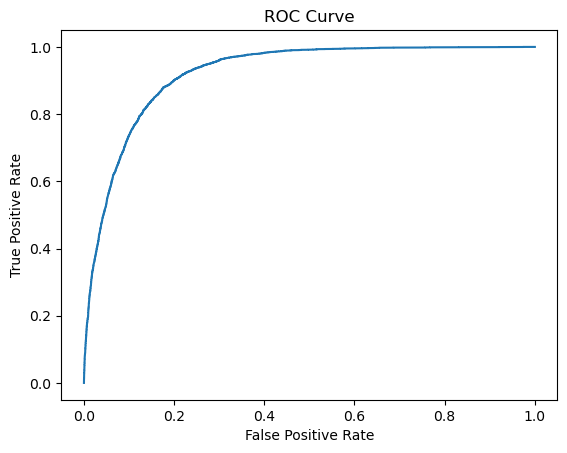

In [22]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


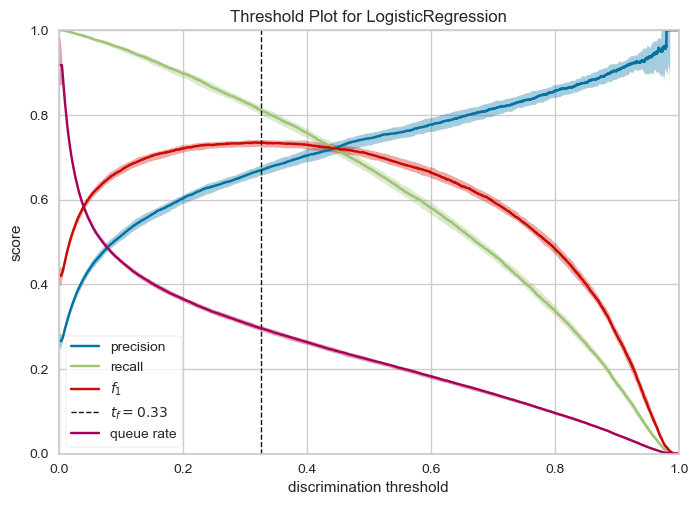

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [27]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(best_param)
visualizer.fit(train_x,train_y)        
visualizer.show()   

In [23]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [24]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8431967863613453
Top 4% capture 0.4389850986709625
Final eval metric 0.641090942516154
